In [ ]:
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from skimage import transform, data
import imageio

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP447/"

Mounted at /content/drive


In [ ]:
# Provided functions
def read_video_into_numpy(filename):
  cap = cv.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames

# 1. Select corners from the first frame using the Harris corner detector.
You can use these lines to get corners:
dst = cv.cornerHarris(gray_img,2,3,0.04)
y,x = np.where(dst > 0.1*dst.max()) # tuple of locations

Can't receive frame (stream end?). Exiting ...


(-0.5, 639.5, 359.5, -0.5)

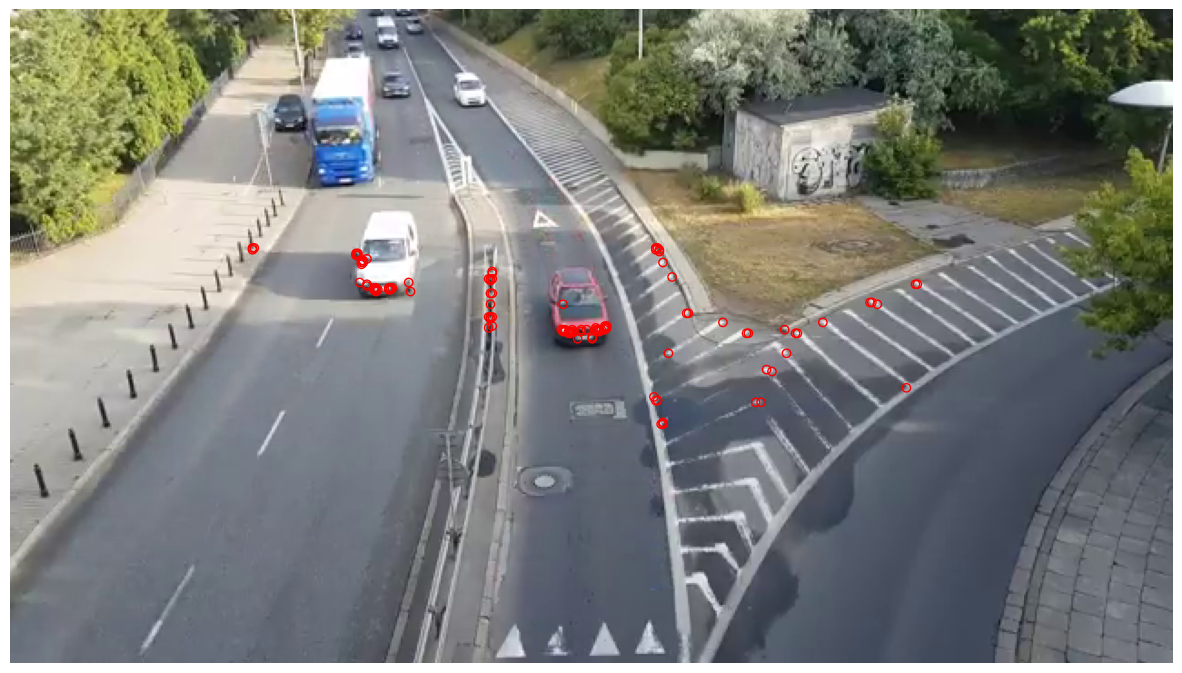

In [ ]:
car = read_video_into_numpy(path + "cars.mp4")
first_frame = car[0]
gray_img = cv.cvtColor(first_frame,cv.COLOR_BGR2GRAY)
height, width = gray_img.shape
dst = cv.cornerHarris(gray_img,2,3,0.04)
y,x = np.where(dst > 0.1*dst.max()) # tuple of locations
# Define threshold
threshold = 130
mask = (x > threshold) & (x < width - threshold) & (y > threshold) & (y < height - threshold)
y, x = y[mask], x[mask]

# Find key points and plot
key_points = np.column_stack((y, x))
plt.figure(figsize=(15,12))
plt.imshow(first_frame)
plt.scatter(key_points[:,1], key_points[:,0],
      facecolors='none', edgecolors=(255/255, 0/255, 0/255))
plt.axis('off')

# 2. Track the points through the entire video by applying Lucas-Kanade between each pair of successive frames.
This will yield one ‘trajectory’ per point, with length equal to the
number of video frames.

In [ ]:
def compute_flow(imgA, imgB, keypoints, cur_flow, window_size):
  # Initialize
  Ax = np.zeros_like(imgA)
  Ay = np.zeros_like(imgB)

  res = []
  w = window_size // 2
  for channel in range(3):
    Ay[:, :, channel], Ax[:, :, channel] = np.gradient(imgA[:, :, channel])

  # For each point
  for i in range(len(keypoints)):
    y_g = int(round(keypoints[i][0]))
    x_g = int(round(keypoints[i][1]))

    # Compute the matrix G in the algo
    Ax_g = Ax[y_g - w : y_g + w + 1, x_g - w : x_g + w + 1, :]
    Ay_g = Ay[y_g - w : y_g + w + 1, x_g - w : x_g + w + 1, :]
    Ax_sqr = np.sum(Ax_g**2)
    Axy = np.sum(Ax_g * Ay_g)
    Ay_sqr = np.sum(Ay_g**2)
    G = np.array([[Ax_sqr, Axy],
            [Axy, Ay_sqr]])
    G_inv = np.linalg.inv(G)

    # For k iterations, apply lucas-kanade refinement
    flow = np.zeros(2)
    for k in range(6):
      flow_x, flow_y = flow
      x2 = int(round(keypoints[i][1] + cur_flow[i][1] + flow_x))
      y2 = int(round(keypoints[i][0] + cur_flow[i][0] + flow_y))

      # Compute the matrix b
      At =  imgA[y_g - w : y_g + w + 1, x_g - w : x_g + w + 1, :] - imgB[y2 - w : y2 + w + 1, x2 - w : x2 + w + 1, :]
      bk0 = np.sum(At * Ax_g)
      bk1 = np.sum(At * Ay_g)
      bk = np.array([bk0,bk1])

      # Update the flow vector
      flow += G_inv @ bk

    res.append([flow[1], flow[0]])
  return res

In [ ]:
def gaussian2D(sigma, kernel_size):
  x_size, y_size = kernel_size
  center_x = x_size // 2
  center_y = y_size // 2

  # Generate 2D Gaussian kernel by applying the low pass filter
  x, y = np.mgrid[-center_x:center_x+1, -center_y:center_y+1]
  sigx = sigma[0]
  sigy = sigma[1]
  kernel = (1 / (2 * np.pi * sigx * sigy)) * np.exp(-((x**2 / (2 * (sigx**2)) + y**2 / (2 * (sigy**2)))))
  kernel = kernel / np.sum(kernel)
  return kernel

def gausspyr(I, n_levels, sigma):
  res = []
  res.append(I)
  for i in range(1, n_levels):
    kernel_size= (int(6*sigma[0]), int(6*sigma[1]))
    kernel = gaussian2D(sigma, kernel_size)
    I_blur = cv.filter2D(I, -1, kernel)

    # Downsample
    downsample_factor = 2
    downsampled = I_blur[::downsample_factor, ::downsample_factor]

    res.append(downsampled)
    I = downsampled
  return res

In [ ]:
def lucas_kanade_algo(video, threshold, n_levels, window_size, circle_size):
  first_frame = video[0]
  gray_img = cv.cvtColor(first_frame,cv.COLOR_BGR2GRAY)
  height, width = gray_img.shape
  dst = cv.cornerHarris(gray_img,2,3,0.04)
  y,x = np.where(dst > 0.1*dst.max()) # tuple of locations
  # Define threshold
  threshold = 130
  mask = (x > threshold) & (x < width - threshold) & (y > threshold) & (y < height - threshold)
  y, x = y[mask], x[mask]

  # Find key points and plot
  keypoints = np.column_stack((y, x))
  plt.figure(figsize=(15,12))
  plt.imshow(first_frame)
  plt.scatter(keypoints[:,1], keypoints[:,0],
        facecolors='none', edgecolors=(255/255, 0/255, 0/255))
  plt.axis('off')

  # Track the points through the entire video
  res = []
  for i in range(len(video)-1):
    imgA = video[i]
    imgB = video[i+1]

    sigma = (4,4)
    gaussian_A = tuple(transform.pyramid_gaussian(imgA, max_layer=n_levels, downscale=2, multichannel=True))
    gaussian_B = tuple(transform.pyramid_gaussian(imgB, max_layer=n_levels, downscale=2, multichannel=True))

    # Initialize flow guess
    cur_flow = np.zeros(keypoints.shape)

    # For each pyramid level
    for i in reversed(range(n_levels)):
      imgA_i = gaussian_A[i]
      imgB_i = gaussian_B[i]
      keypoints_i = keypoints / (2 ** i)

      # Compute for each point
      flow = compute_flow(imgA_i, imgB_i, keypoints_i, cur_flow, window_size)

      # Optical flow guess for next level
      if i > 0:
        cur_flow = 2 * (cur_flow + flow)
    flow = flow + cur_flow

    next_keypoints = keypoints + flow

    for pts in next_keypoints:
      cv.circle(imgA, (int(pts[1]), int(pts[0])), circle_size, (255,0,0), 1)

    res.append(imgA)
    keypoints = next_keypoints
  return res

<ipython-input-19-a978f5a476f0>:27: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian_A = tuple(transform.pyramid_gaussian(imgA, max_layer=n_levels, downscale=2, multichannel=True))
<ipython-input-19-a978f5a476f0>:28: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian_B = tuple(transform.pyramid_gaussian(imgB, max_layer=n_levels, downscale=2, multichannel=True))


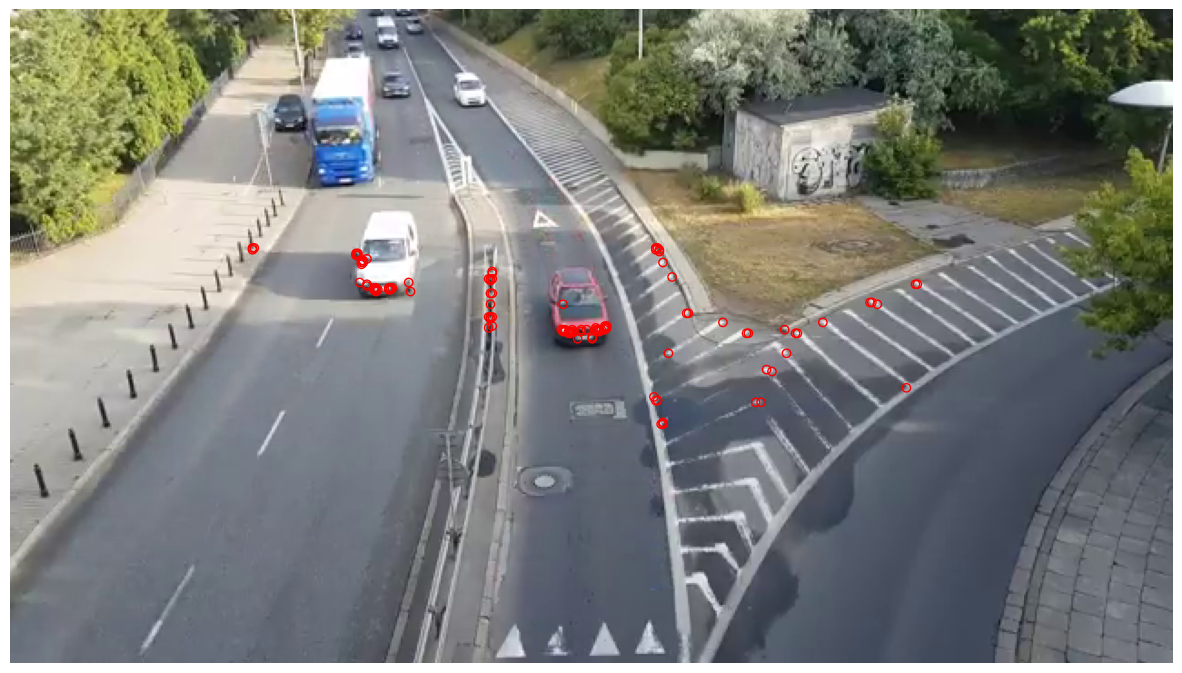

In [ ]:
# Initialize parameters
n_levels = 3
window_size = 10
circle_size = 4

im_list = lucas_kanade_algo(car, threshold, n_levels, window_size, circle_size)

# Create a gif showing the tracked points overlaid as circles on the original frames
imageio.mimsave(path + 'tracking.gif', im_list, fps=10)

# 3.1 Use PCA to model patches (5 points)
Randomly sample at least 1,000 16 x 16 patches from the image. Flatten those patches into vectors (should be of size 16 x 16 x 3). Run PCA on these patches to obtain a set of principal components. Please write your own code to perform PCA. You may use numpy.linalg.eigh, or numpy.linalg.svd to obtain eigenvectors.

In [ ]:
def pca(img):
  patch_x = int(img.shape[0] / 16)
  patch_y = int(img.shape[1] / 16)
  num_patches = (patch_x + 1) * (patch_y + 1)
  patches = []

  # extract patches
  for i in range(patch_x + 1):
    for j in range(patch_y):
      if i == patch_x:
        patch = img[img.shape[0] - 16 : img.shape[0], j * 16 : j * 16 + 16, :]
        patches.append(patch)
        if j == patch_y - 1 :
          patch = img[img.shape[0] - 16 : img.shape[0], img.shape[1] - 16 : img.shape[1], :]
          patches.append(patch)
      else:
        patch = img[i * 16 : i * 16 + 16, j * 16 : j * 16 + 16, :]
        patches.append(patch)
        if j == patch_y - 1 :
          patch = img[i * 16 : i * 16 + 16, img.shape[1] - 16 : img.shape[1], :]
          patches.append(patch)

  # flatten patches into vectors
  flat_patches = np.array(patches).reshape(num_patches, -1)

  # start pca procedure
  x_mean = np.mean(flat_patches, axis=0)
  patches_no_mean = flat_patches - x_mean

  c = np.dot(patches_no_mean.T, patches_no_mean)

  # compute eigenvectors of c
  eigenvalues, eigenvectors = np.linalg.eigh(c)

  # sort the eigenvectors by decreasing eigenvalue magnitude
  idx = np.argsort(eigenvalues)[::-1]
  eigenvalues_sorted = eigenvalues[idx]
  eigenvectors_sorted = eigenvectors[:, idx]

  return flat_patches, patches, x_mean, eigenvalues, eigenvectors, eigenvalues_sorted, eigenvectors_sorted

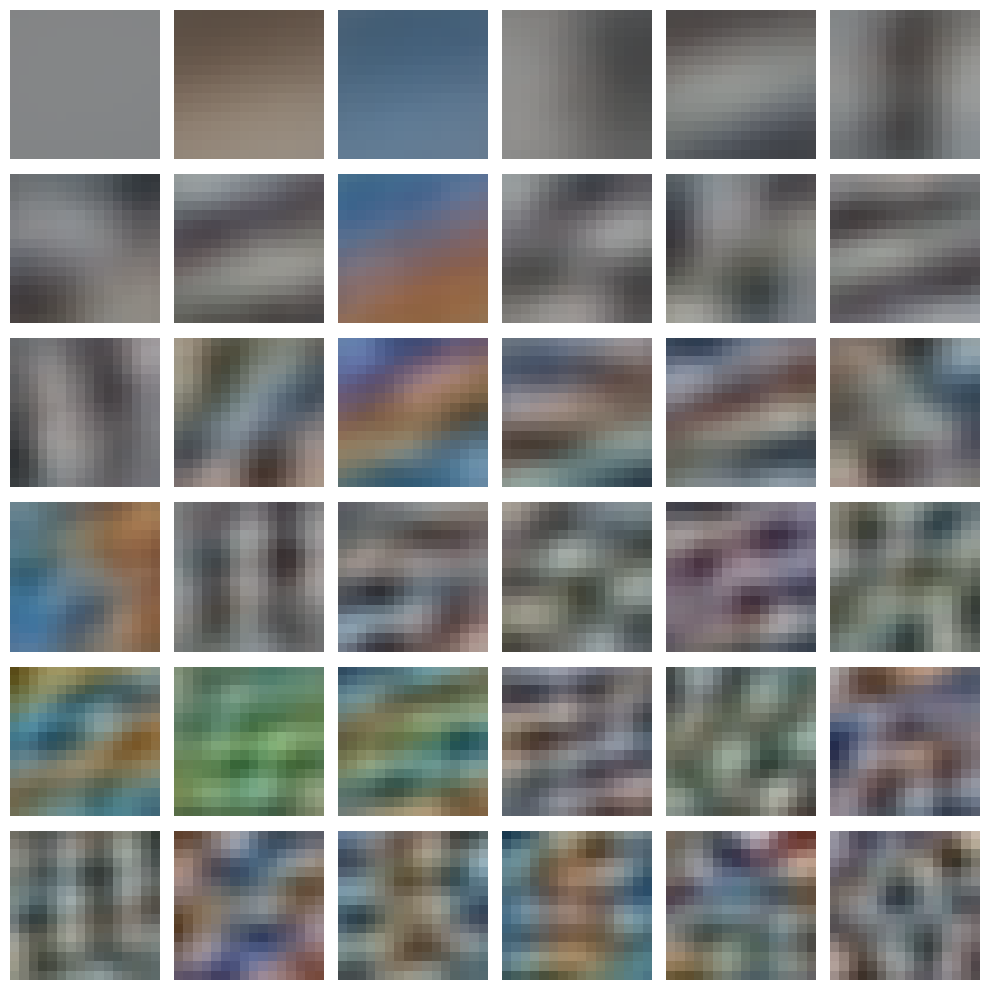

In [ ]:
# Station
station = Image.open(path + 'station.png')
station = np.array(station)
flat_patches, patches, x_mean, eigenvalues, eigenvectors, eigenvalues_sorted, eigenvectors_sorted = pca(station)
eigenvectors_sorted = cv.normalize(eigenvectors_sorted, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

# Display the first 36 principal components
fig, ax = plt.subplots(6, 6, figsize=(10, 10))
index = 0
for i in range(6):
  for j in range(6):
    principal_comp = eigenvectors_sorted[:, i * 6 + j].reshape(16, 16, 3)
    ax[i][j].imshow(principal_comp)
    ax[i][j].axis('off')

plt.tight_layout()
plt.show()

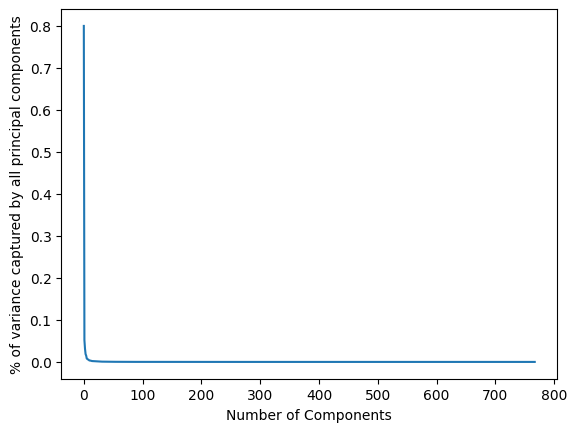

In [ ]:
# % of variance
variances = eigenvalues_sorted / np.sum(eigenvalues_sorted)

# Plot the % of variance explained by that component
plt.plot(variances)
plt.xlabel('Number of Components')
plt.ylabel('% of variance captured by all principal components')
plt.show()

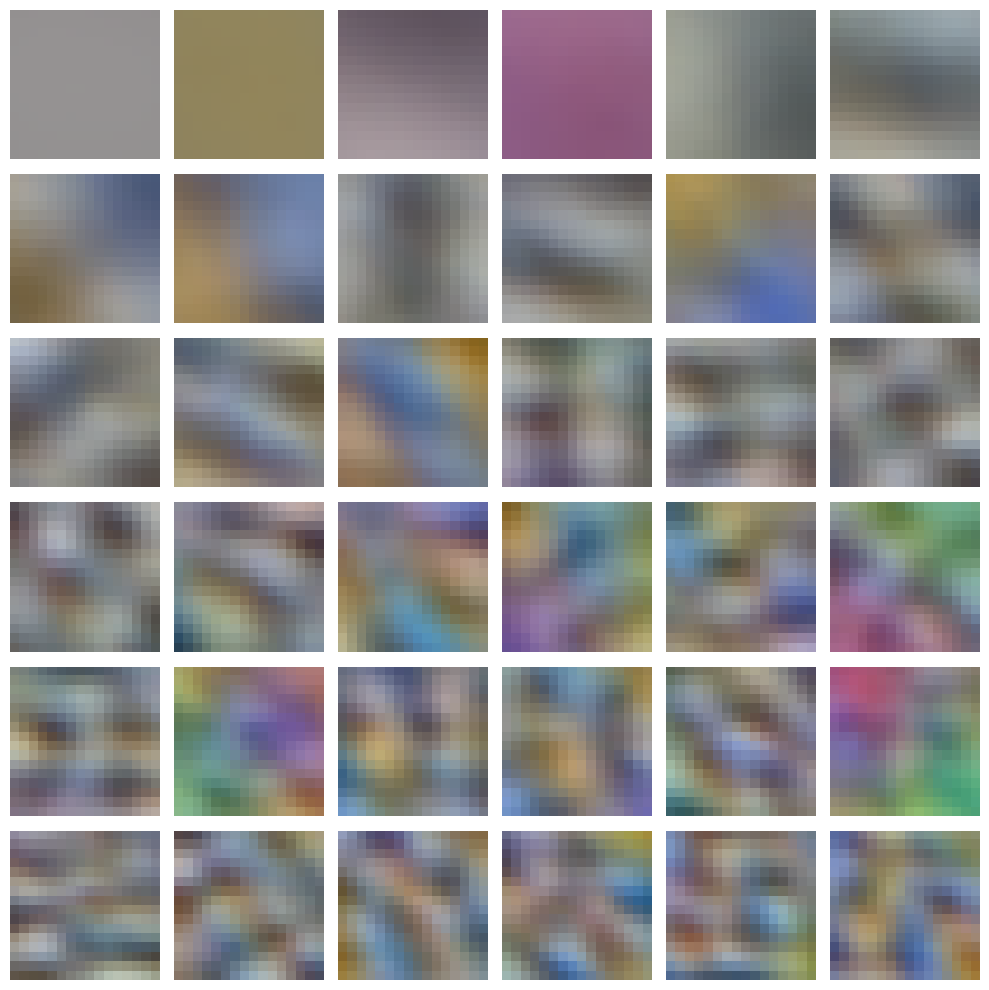

In [ ]:
# parrot
parrot = Image.open(path + 'parrot.png')
parrot = np.array(parrot)
flat_patches, patches, x_mean, eigenvalues, eigenvectors, eigenvalues_sorted, eigenvectors_sorted = pca(parrot)
eigenvectors_sorted = cv.normalize(eigenvectors_sorted, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

# Display the first 36 principal components
fig, ax = plt.subplots(6, 6, figsize=(10, 10))
index = 0
for i in range(6):
  for j in range(6):
    principal_comp = eigenvectors_sorted[:, i * 6 + j].reshape(16, 16, 3)
    ax[i][j].imshow(principal_comp)
    ax[i][j].axis('off')

plt.tight_layout()
plt.show()

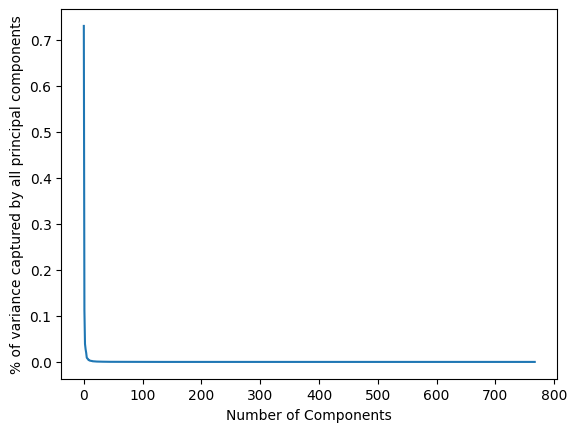

In [ ]:
# % of variance
variances = eigenvalues_sorted / np.sum(eigenvalues_sorted)

# Plot the % of variance explained by that component
plt.plot(variances)
plt.xlabel('Number of Components')
plt.ylabel('% of variance captured by all principal components')
plt.show()

# 3.2 Compress the image (5 points)
Show image reconstruction results using 1, 3, 10, 50, and 100 principal components. To do this,
divide the image into non-overlapping 16 x 16 patches, and reconstruct each patch
independently using the principal components.

In [ ]:
def image_reconstruction(image, flat_patches, x_mean, eigenvectors):
  patches = np.dot(flat_patches, eigenvectors) @ eigenvectors.T + x_mean
  reshaped_patches = [patch.reshape(16, 16, 3) for patch in patches]

  patch_x = image.shape[0] // 16 + 1
  patch_y = image.shape[1] // 16 + 1
  last_x = image.shape[0] - 16 * (patch_x - 1)
  last_y = image.shape[1] - 16 * (patch_y - 1)

  # Initialize the image array
  res = np.zeros([patch_x, patch_y, 3])

  # start compressing
  idx = 0
  for i in range(patch_x):
    is_last_row = (i == patch_x - 1)
    if is_last_row:
      row = reshaped_patches[idx][16 - last_x : 16, :, :]
    else:
      row = reshaped_patches[idx]
    idx += 1
    for j in range(1, patch_y):
      is_last_col = (j == patch_y - 1)
      if is_last_row and is_last_col:
        new_row = reshaped_patches[idx][16 - last_x : 16, 16 - last_y : 16, :]
      elif is_last_row:
        new_row = reshaped_patches[idx][16 - last_x : 16, :, :]
      elif is_last_col:
        new_row = reshaped_patches[idx][:, 16 - last_y : 16, :]
      else:
        new_row = reshaped_patches[idx]
      row = np.concatenate((row, new_row), axis=1)
      idx += 1
    if i != 0:
      compressed = np.concatenate((compressed, row), axis=0)
    else:
      compressed = row
  res = compressed
  return res

<Figure size 640x480 with 0 Axes>

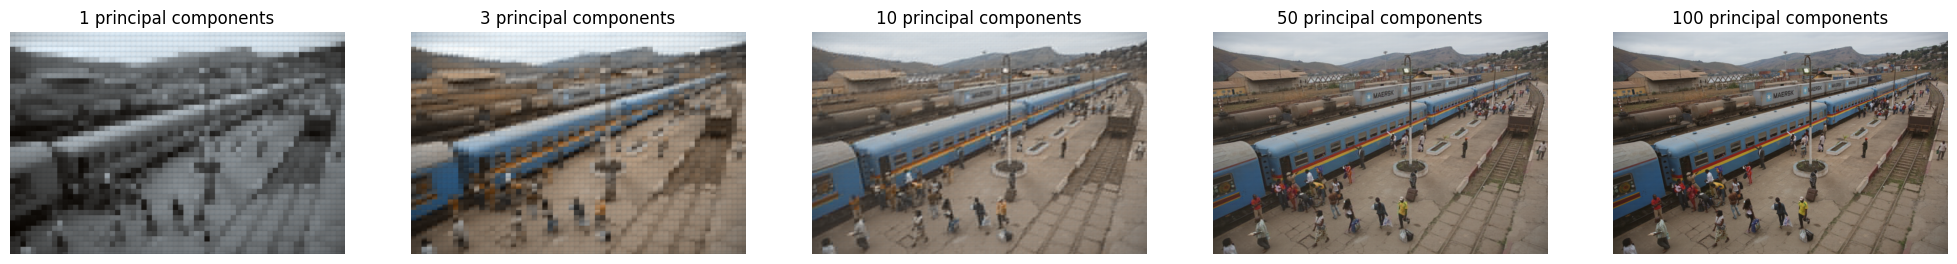

In [ ]:
station = Image.open(path + 'station.png')
station = np.array(station)
flat_patches, patches, x_mean, eigenvalues, eigenvectors, eigenvalues_sorted, eigenvectors_sorted = pca(station)

# Using different number of principal components
principal_comp_1 = eigenvectors_sorted[:,:1]
principal_comp_3 = eigenvectors_sorted[:,:3]
principal_comp_10 = eigenvectors_sorted[:,:10]
principal_comp_50 = eigenvectors_sorted[:,:50]
principal_comp_100 = eigenvectors_sorted[:,:100]

res = []
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_1))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_3))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_10))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_50))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_100))

for i in range(len(res)):
  res[i] = res[i].astype(np.float32)
  res[i] = (res[i] - np.min(res[i])) / (np.max(res[i]) - np.min(res[i]))

plt.figure()
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
titles = ["1 principal components", "3 principal components", "10 principal components",
      "50 principal components", "100 principal components"]
idx = 0
for j in range(5):
  ax[j].imshow(res[idx])
  ax[j].axis('off')
  ax[j].set_title(f"{titles[idx]}")
  idx += 1
plt.show()

<Figure size 640x480 with 0 Axes>

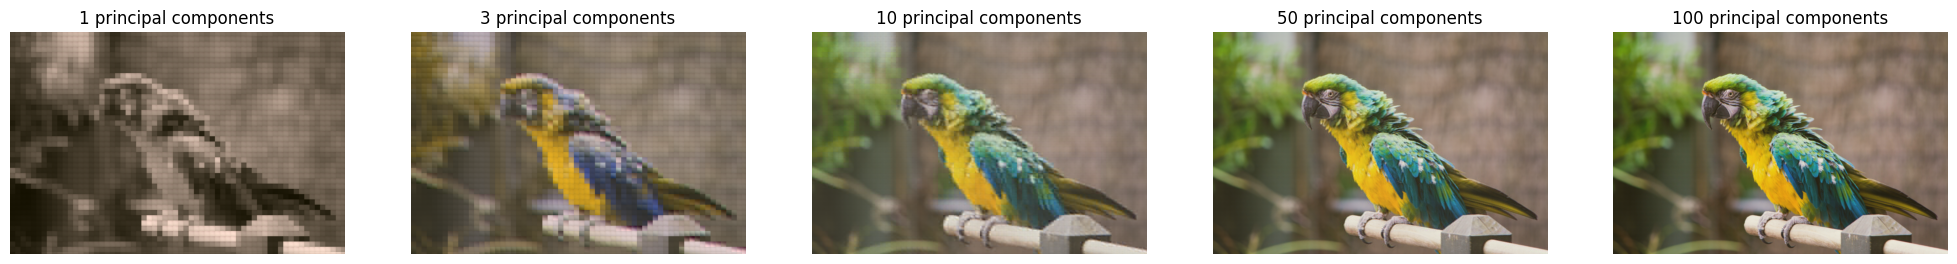

In [ ]:
parrot = Image.open(path + 'parrot.png')
parrot = np.array(parrot)
flat_patches, patches, x_mean, eigenvalues, eigenvectors, eigenvalues_sorted, eigenvectors_sorted = pca(parrot)

# Using different number of principal components
principal_comp_1 = eigenvectors_sorted[:,:1]
principal_comp_3 = eigenvectors_sorted[:,:3]
principal_comp_10 = eigenvectors_sorted[:,:10]
principal_comp_50 = eigenvectors_sorted[:,:50]
principal_comp_100 = eigenvectors_sorted[:,:100]

res = []
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_1))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_3))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_10))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_50))
res.append(image_reconstruction(station, flat_patches, x_mean, principal_comp_100))

for i in range(len(res)):
  res[i] = res[i].astype(np.float32)
  res[i] = (res[i] - np.min(res[i])) / (np.max(res[i]) - np.min(res[i]))

plt.figure()
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
titles = ["1 principal components", "3 principal components", "10 principal components",
      "50 principal components", "100 principal components"]
idx = 0
for j in range(5):
  ax[j].imshow(res[idx])
  ax[j].axis('off')
  ax[j].set_title(f"{titles[idx]}")
  idx += 1
plt.show()